In [34]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [35]:
# Load Data
%store -r X_train X_test y_train y_test X_train_pca X_test_pca
%store -r koi_reduced_df reduced_df

X_train_pca = X_train_pca.copy()
X_test_pca = X_test_pca.copy()
X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()

In [36]:
# Initialize the logistic regression model with the multinomial option
log_reg_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fit the model
log_reg_multi.fit(X_train, y_train)

# Predict on the training set (or test set as needed)
y_pred = log_reg_multi.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.80      0.41      0.54       939
           2       0.69      0.94      0.80      1361

    accuracy                           0.71      2324
   macro avg       0.50      0.45      0.45      2324
weighted avg       0.73      0.71      0.68      2324



c:\Users\logan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\logan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\logan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:147

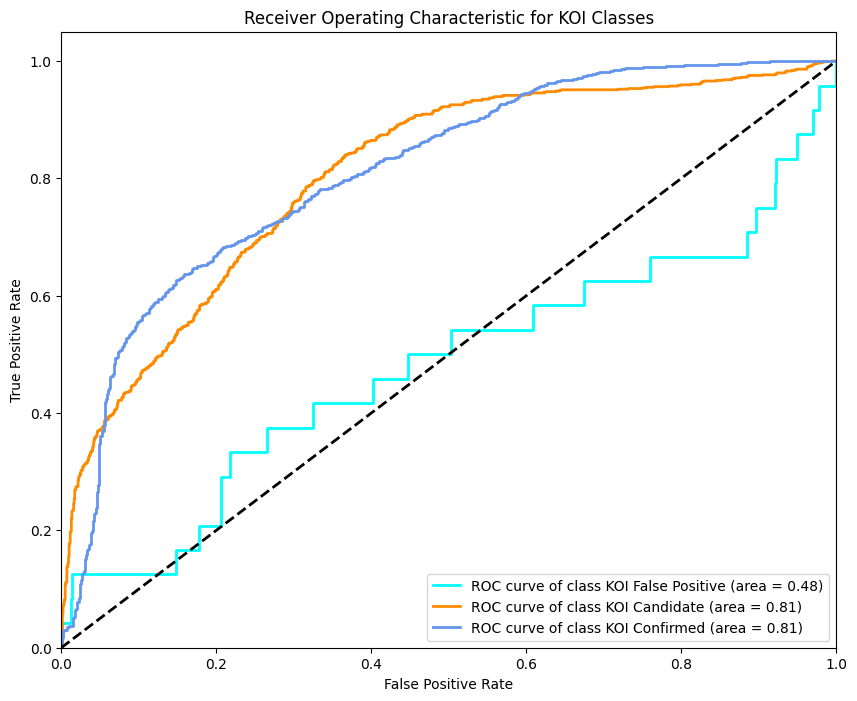

In [37]:
# ROC curve

y_pred_prob = log_reg_multi.predict_proba(X_test)

# Binarizing the output with the actual class names this time
class_names = ["KOI False Positive", "KOI Candidate", "KOI Confirmed"]  # Class names
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Ensure y_test is encoded as 0, 1, 2 before binarizing
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KOI Classes')
plt.legend(loc="lower right")
plt.show()

The model's accuracy of approximately 71.43% indicates it correctly predicts the class of an observation about 71% of the time across all classes. However, its performance varies significantly among the classes. It completely fails to identify "False Negative" classes (0% precision and recall), while it performs decently on "Candidate" classes (80% precision, 41% recall) and best on "Confirmed" classes (69% precision, 94% recall). The low macro average F1-score (0.45) compared to the weighted average (0.68) suggests the model is influenced by its performance on the more prevalent classes (Candidate and Confimred). The ROC curves indicate that the model distinguishes between "KOI Candidate" and "KOI Confirmed" effectively, with an AUC of 0.81 for both, suggesting good classification performance for these categories. The curve for "KOI False Positive" shows an AUC of 0.48, which is below random chance. The graph suggests that while the model performs well for confirming candidates or confirming non-candidates, it struggles to correctly identify false positives, which may require further model tuning or data rebalancing.
